In [ ]:
!pip install datasets scikit-learn matplotlib seaborn nltk

In [9]:
from datasets import load_dataset
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [10]:
# Load the dataset
dataset = load_dataset("imdb", split="train")

# Extract the text data and labels
texts = dataset["text"]
labels = dataset["label"]

# Convert to DataFrame
data = pd.DataFrame({'text': texts, 'label': labels})

# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Lowercase text
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

data['clean_text'] = data['text'].apply(preprocess_text)

In [11]:
# Convert the text into vectors using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(data['clean_text'])

# Choose the number of clusters
num_clusters = 2

# Initialize K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit K-Means
kmeans.fit(X)

# Get cluster labels
data['cluster'] = kmeans.labels_

In [12]:
# Analyze clusters to determine which sentiment each cluster represents
clustered_data = data.groupby('cluster').apply(lambda x: ' '.join(x['clean_text'])).reset_index()
clustered_data.columns = ['cluster', 'text']

for i in range(num_clusters):
    print(f"Cluster {i} words:")
    cluster_text = clustered_data[clustered_data['cluster'] == i]['text'].values[0]
    words = cluster_text.split()
    word_freq = pd.Series(words).value_counts().head(20)
    print(word_freq)
    print()

Cluster 0 words:
the      84121
a        41233
and      39590
to       35024
of       33823
i        30650
movie    28806
is       27078
this     26672
it       26127
in       21804
that     20230
was      16919
br       15704
but      12218
for      11382
you      11318
with     10050
not       9631
as        9582
Name: count, dtype: int64

Cluster 1 words:
the     250632
and     122652
a       120724
of      111509
to      100023
is       79778
in       71234
it       50983
that     49121
this     48524
i        45086
br       41977
as       37082
with     33821
film     33117
for      32583
was      31089
but      29532
on       24996
his      24548
Name: count, dtype: int64



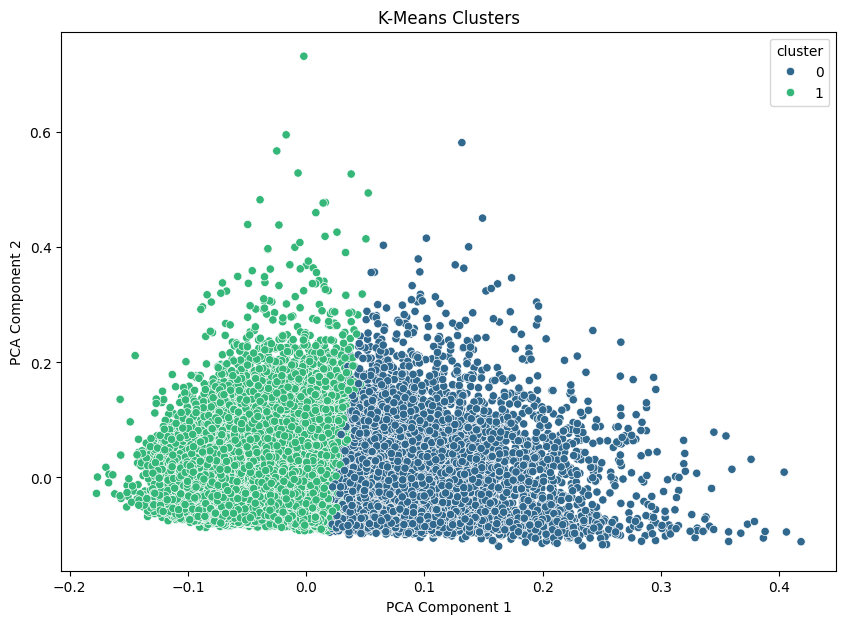

In [13]:
# Optional: Visualize clusters using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['cluster'], palette='viridis')
plt.title('K-Means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [14]:
# Define a mapping from cluster numbers to sentiment labels
cluster_to_sentiment = {0: 0, 1: 1}  # Adjust according to your analysis

# Map the cluster labels to the numeric sentiment labels
data['predicted_sentiment'] = data['cluster'].map(cluster_to_sentiment)

# Calculate accuracy
accuracy = accuracy_score(data['label'], data['predicted_sentiment'])
print(f'Accuracy: {accuracy:.2f}')

# Evaluate the results
print(classification_report(data['label'], data['predicted_sentiment']))

Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.63      0.37      0.47     12500
           1       0.55      0.78      0.65     12500

    accuracy                           0.58     25000
   macro avg       0.59      0.58      0.56     25000
weighted avg       0.59      0.58      0.56     25000

